In [137]:
#Dependencies
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

In [3]:
# Store the file path associated with the file
csvpath = "./Resources/breweries.csv"
data_df = pd.read_csv(csvpath)

#Only grab the fields we need from the data frame
grab_fields_df = data_df[["name", "brewery_type", 'city', "state", 'country']]
grab_fields_df.describe()


#Rename our headers
renamed_df = grab_fields_df.rename(columns={"name":"Brewery Name", "brewery_type":"Type of Brewery",
                                    "city": "City", "state": "State", "country": "Country"})
renamed_df.head()

,Brewery Name,Type of Brewery,City,State,Country
0,10-56 Brewing Company,micro,Knox,Indiana,United States
1,10 Barrel Brewing Co,large,Bend,Oregon,United States
2,10 Barrel Brewing Co,large,Bend,Oregon,United States
3,10 Barrel Brewing Co - Bend Pub,large,Bend,Oregon,United States
4,10 Barrel Brewing Co - Boise,large,Boise,Idaho,United States


In [229]:
# Also going to remove Scotland breweries sice majority is for US
types_us_df = renamed_df.loc[renamed_df["Country"] == "United States"].reset_index(drop = True)
types_us_df

types_us_df.groupby("Type of Brewery").count() #Verify no missing data

types_df = types_us_df.loc[(types_us_df["Type of Brewery"] != 'bar' )&
              (types_us_df["Type of Brewery"] != 'nano')&
                          (types_us_df["Type of Brewery"] != 'closed')&
                          (types_us_df["Type of Brewery"] != 'planning')]
types_df
types_df.groupby("Type of Brewery").count() 

len(types_df["State"].unique()) # Has a count of 52 expecting 51
types_df["State"].unique() # There is one instance where Missouri is spelt MIssouri

cleaned_df = types_df.replace({"MIssouri": "Missouri"})
len(cleaned_df["State"].unique()) #Resolved

count_state = cleaned_df["State"].value_counts()

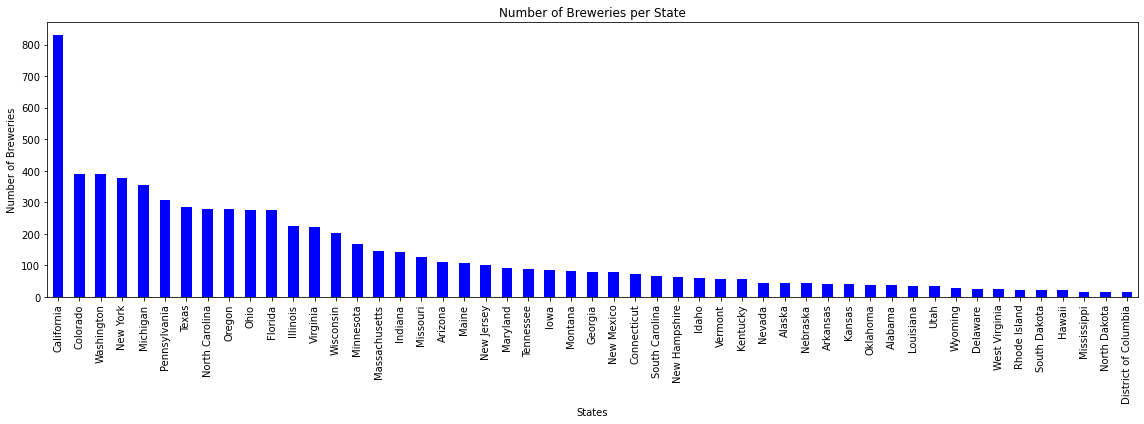

In [230]:
#Plot count of breweries per state
count_state.plot(kind="bar", facecolor="blue", figsize = (16, 6))

# Set textual properties
plt.title("Number of Breweries per State")
plt.ylabel("Number of Breweries")
plt.xlabel("States")

# # Show plot
# plt.show()

# Resize plot to display labels
plt.tight_layout()

plt.savefig("num_breweries_per_state.png")

In [6]:
#grab top 5 states with most breweries
cleaned_df["State"].value_counts().keys()
states = []

for state in range(0, 10):
    print(cleaned_df["State"].value_counts().keys()[state])
    states.append(cleaned_df["State"].value_counts().keys()[state])
    
top_five_df = cleaned_df.loc[cleaned_df["State"].isin(states)]
top_five_df

California
Colorado
Washington
New York
Michigan
Pennsylvania
Texas
North Carolina
Oregon
Ohio


,Brewery Name,Type of Brewery,City,State,Country
1,10 Barrel Brewing Co,large,Bend,Oregon,United States
2,10 Barrel Brewing Co,large,Bend,Oregon,United States
3,10 Barrel Brewing Co - Bend Pub,large,Bend,Oregon,United States
5,10 Barrel Brewing Co - Denver,large,Denver,Colorado,United States
6,10 Barrel Brewing Co,large,Portland,Oregon,United States
...,...,...,...,...,...
7778,Zoiglhaus Brewing Company,brewpub,Portland,Oregon,United States
7779,Zone 9 Brewing Company,micro,Clovis,California,United States
7782,Zuni Street Brewing Company,micro,Denver,Colorado,United States
7784,Zwei Brewing Co,micro,Fort Collins,Colorado,United States


In [7]:
#Create new Data Frame using dummies (Thanks Bill) so each brewery type has its own column for plotting
dummy_df = pd.get_dummies(top_five_df["Type of Brewery"], prefix = "Type")

#Merge with original data frame to plot by state
merged_df = pd.merge(top_five_df, dummy_df, on=None, left_index = True, right_index = True)
merged_df

,Brewery Name,Type of Brewery,City,State,Country,Type_brewpub,Type_contract,Type_large,Type_micro,Type_proprietor,Type_regional
1,10 Barrel Brewing Co,large,Bend,Oregon,United States,0,0,1,0,0,0
2,10 Barrel Brewing Co,large,Bend,Oregon,United States,0,0,1,0,0,0
3,10 Barrel Brewing Co - Bend Pub,large,Bend,Oregon,United States,0,0,1,0,0,0
5,10 Barrel Brewing Co - Denver,large,Denver,Colorado,United States,0,0,1,0,0,0
6,10 Barrel Brewing Co,large,Portland,Oregon,United States,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
7778,Zoiglhaus Brewing Company,brewpub,Portland,Oregon,United States,1,0,0,0,0,0
7779,Zone 9 Brewing Company,micro,Clovis,California,United States,0,0,0,1,0,0
7782,Zuni Street Brewing Company,micro,Denver,Colorado,United States,0,0,0,1,0,0
7784,Zwei Brewing Co,micro,Fort Collins,Colorado,United States,0,0,0,1,0,0


In [8]:
#Finialize DF by grouping by state and aggregrate by the count for ech brewery type
merged_df[["State", "Type_micro", "Type_brewpub" , "Type_contract", 
           "Type_regional", "Type_large", "Type_proprietor"]]
renamed_merged_df = merged_df.rename(columns = {"Type_contract": "Contract", 
                                                "Type_micro": "Micro",
                                               "Type_brewpub": "Brewpub",
                                               "Type_large": "Large",
                                               "Type_proprietor": "Proprietor",
                                               "Type_regional": "Regional"})

plot_df = renamed_merged_df.groupby("State").sum()
plot_df = plot_df[["Micro", "Brewpub", "Contract", "Regional", "Large", "Proprietor"]]

x = np.arange(0,len(plot_df["Brewpub"]),1)
plot_df

,Micro,Brewpub,Contract,Regional,Large,Proprietor
State,,,,,,
California,489.0,251.0,31.0,29.0,16.0,13.0
Colorado,220.0,138.0,9.0,11.0,7.0,4.0
Michigan,143.0,199.0,3.0,9.0,0.0,0.0
New York,221.0,111.0,22.0,9.0,4.0,10.0
North Carolina,180.0,73.0,5.0,13.0,4.0,3.0
Ohio,163.0,94.0,7.0,9.0,2.0,1.0
Oregon,147.0,105.0,3.0,14.0,6.0,2.0
Pennsylvania,129.0,156.0,6.0,13.0,0.0,2.0
Texas,187.0,76.0,6.0,10.0,4.0,1.0


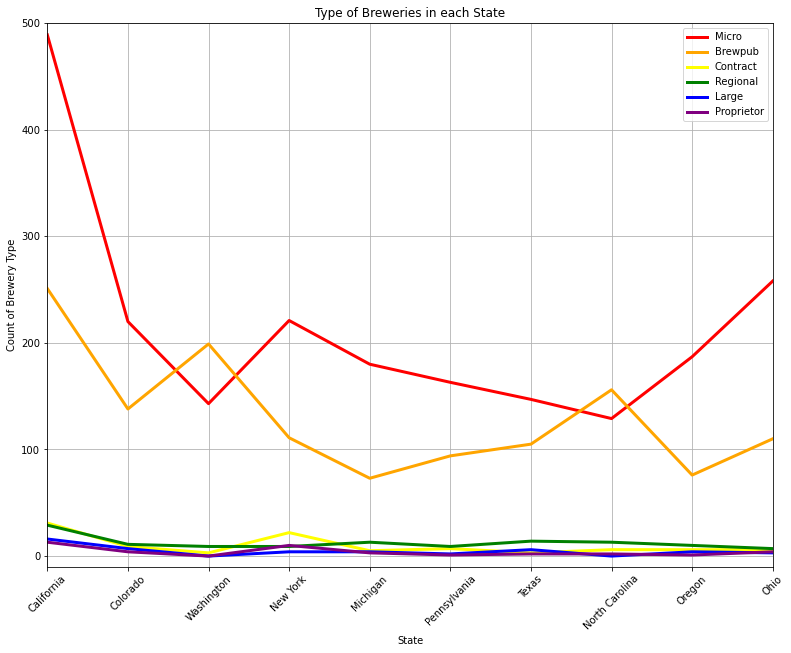

In [9]:
# Plot the charts and apply some styling
plt.figure(figsize=(13,10))
micro, = plt.plot(x, plot_df["Micro"], color="red", linewidth=3, label="Micro")
brewpub, = plt.plot(x, plot_df["Brewpub"], color="orange", linewidth=3, label="Brewpub")
contract, = plt.plot(x, plot_df["Contract"], color="yellow", linewidth=3, label="Contract")
regional, = plt.plot(x, plot_df["Regional"], color="green", linewidth=3, label="Regional")
large, = plt.plot(x, plot_df["Large"], color="blue", linewidth=3, label="Large")
proprietor, = plt.plot(x, plot_df["Proprietor"], color="purple", linewidth=3, label="Proprietor")

# Add labels to X and Y axes :: Add title
plt.title("Type of Breweries in each State")
plt.xlabel("State")
plt.ylabel("Count of Brewery Type")

# Set the limits for the X and Y axes

plt.xlim(0,9)
plt.ylim(-10,500)
plt.xticks(x, states, rotation= 45)

# Create a legend for the chart
plt.legend(handles=[micro, brewpub, contract, regional, large, proprietor], loc="best")

# Add in a grid for the chart
plt.grid()
# plt.show()

plt.savefig("type_breweries_per_state.png")

In [ ]:
cleaned_df

In [ ]:
top_five_df

In [10]:
#Next I want to merge the original data frame to a new data set that also has brewery info
# Store the file path associated with the file
csvpath = "./Resources/breweries_k.csv"
breweries_k_df = pd.read_csv(csvpath)
renamed_breweries_k_df = breweries_k_df.rename(columns = {"Unnamed: 0": "Brewery ID", "name": "Brewery Name"})
interim_df = renamed_breweries_k_df[["Brewery ID", "Brewery Name"]]
interim_df

# Need to merge these table in order to merge to beers DF on Brew ID
merged_breweries_df = pd.merge(cleaned_df, interim_df, on="Brewery Name")


In [143]:
#Next I want to incorporate beer data
# Store the file path associated with the file
csvpath = "./Resources/beers.csv"
data_df = pd.read_csv(csvpath)
beers_df = data_df[["name", "style", "brewery_id", 'abv']]
beers_df = beers_df.rename(columns = {"name": "Beer Name",
                          "style": "Style of Beer", 
                          "brewery_id": "Brewery ID"})

#Now merge beer data 
merged_all_df = pd.merge(merged_breweries_df, beers_df, on="Brewery ID")

merged_all_df.dropna(how = 'any')
merged_all_df['Style of Beer'].unique()
merged_all_df

merged_all_df.to_csv("./mergedAll.csv", index=False, header=True)

In [80]:
#Create new Data Frame using dummies (Thanks Bill) so each brewery type has its own column for plotting
dummy_df = pd.get_dummies(merged_all_df["Style of Beer"], prefix = "Type")

#Merge with original data frame to plot by state
merged_df = pd.merge(merged_all_df, dummy_df, on=None, left_index = True, right_index = True)
merged_df

#Finialize DF by grouping by state and aggregrate by the count for ech brewery type
merged_df[["Type of Brewery", "Type_American Pale Ale (APA)"]]
renamed_merged_df = merged_df.rename(columns = {"Type_American Pale Ale (APA)": "American Pale Ale (APA)",
                                               "Type_American IPA": "American IPA",
                                               "Type_American Double / Imperial IPA": "Imperial IPA",
                                               "Type_American Amber / Red Ale": "Red Ale",
                                               "Type_American Pale Wheat Ale": "Wheat Ale",
                                               "Type_Saison / Farmhouse Ale": "Saison",
                                               "Type_American Blonde Ale": "Blonde Ale",
                                               "Type_American Brown Ale": "Brown Ale",
                                               "Type_American Porter": "Porter",
                                               "Type_Kölsch": "Kölsch",
                                               "Type_American Stout": "Stout",
                                               "Type_Fruit / Vegetable Beer": "Fruit Beer",
                                               "Type_American Black Ale": "Black Ale",
                                               "Type_Belgian IPA": "Belgian IPA",
                                               "Type_American Pale Lager": "Pale Lager",
                                               "Type_American Adjunct Lager": "Adjunct Lager",
                                               "Type_Belgian Pale Ale": "Belgian Pale Ale",
                                               "Type_Cream Ale": "Cream Ale",
                                               "Type_Witbier": "Witbier"})

renamed_merged_df = renamed_merged_df[["Type of Brewery", "American IPA", "American Pale Ale (APA)",
                                       "Imperial IPA", "Red Ale", "Wheat Ale", "Saison", "Blonde Ale",
                                        "Brown Ale", "Porter", "Kölsch", "Stout", "Fruit Beer", "Black Ale",
                                       "Belgian IPA", "Pale Lager", "Adjunct Lager", "Belgian Pale Ale",
                                       "Cream Ale", "Witbier"]]

index = renamed_merged_df["Type of Brewery"].value_counts().keys()
renamed_merged_df.groupby("Type of Brewery").sum()
beer_plot_df = renamed_merged_df.groupby("Type of Brewery").sum().set_index(index)
beer_plot_df


Index(['micro', 'regional', 'brewpub', 'large', 'proprietor', 'contract'], dtype='object')

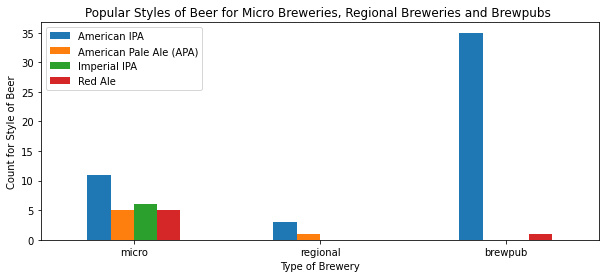

In [228]:
#Plot time
x_values = np.arange(0, 3, 1)
x_values
renamed_merged_df["Type of Brewery"].value_counts().keys()

bar_plot_data = beer_plot_df.iloc[0:3, 0:4]
bar_plot_data.plot(kind = 'bar', figsize = (10, 4))


xticks = []

for x in range(0, 3):
    xticks.append(index[x])

# Add labels to X and Y axes :: Add title
plt.title("Popular Styles of Beer for Micro Breweries, Regional Breweries and Brewpubs ")
plt.xlabel("Type of Brewery")
plt.ylabel("Count for Style of Beer")
plt.xticks(x_values, xticks, rotation= "horizontal")
plt.savefig("type_beer_per_brew_type.png")


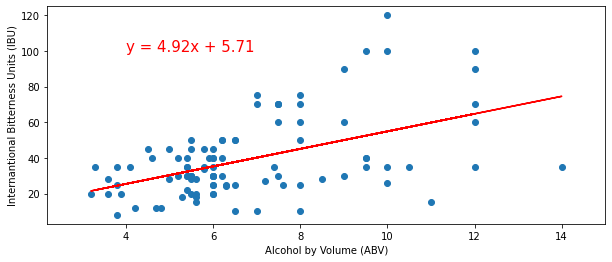

In [141]:
# Store the file path associated with the file
csvpath = "./2015_Guidelines.csv"
data_df = pd.read_csv(csvpath)
styles_df = data_df[["Styles", "ABV max", "IBUs max"]]
styles_df = styles_df.iloc[0:100, :]
styles_df

abvs = styles_df["ABV max"].astype(float)
ibus = styles_df["IBUs max"].astype(float)

max(abvs)

plt.figure(figsize=(10,4))

(slope, intercept, rvalue, pvalue, stderr) = linregress(abvs, ibus)
regress_values = abvs * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(abvs,regress_values,"r-")
plt.annotate(line_eq,(4,100),fontsize=15,color="red")

plt.scatter(abvs, ibus)
plt.xlabel("Alcohol by Volume (ABV)")
plt.ylabel("Internantional Bitterness Units (IBU)")
plt.xlim(min(abvs) - 1, max(abvs) + 1)
plt.ylim(min(ibus) - 5, max(ibus)+ 5)

plt.savefig("lin_reg.png")

In [214]:
#Put style in a series
merged_all_df["Style of Beer"].unique()
styles = merged_all_df.loc[(merged_all_df["Style of Beer"] == 'American IPA') |
         ( merged_all_df["Style of Beer"] == 'American Pale Ale (APA)' )|
          (merged_all_df["Style of Beer"] == 'American Double / Imperial IPA' )|
         ( merged_all_df["Style of Beer"] == 'American Amber / Red Ale' )]

styles = styles["Style of Beer"].unique()

#Create empty list
styles_abv_data = []


In [215]:
for beer in styles:
    print(beer)
    df = merged_all_df.loc[merged_all_df["Style of Beer"] == beer, :].dropna(how = 'any')
    styles_abv_data.append(df["abv"])
    
IPA = merged_all_df.loc[merged_all_df["Style of Beer"] == "American IPA", :]
IPA = IPA["abv"]
IPA.mean()
IPA.median()
IPA.std()

American Pale Ale (APA)
American IPA
American Double / Imperial IPA
American Amber / Red Ale


0.009576548802972679

<Figure size 1152x576 with 0 Axes>

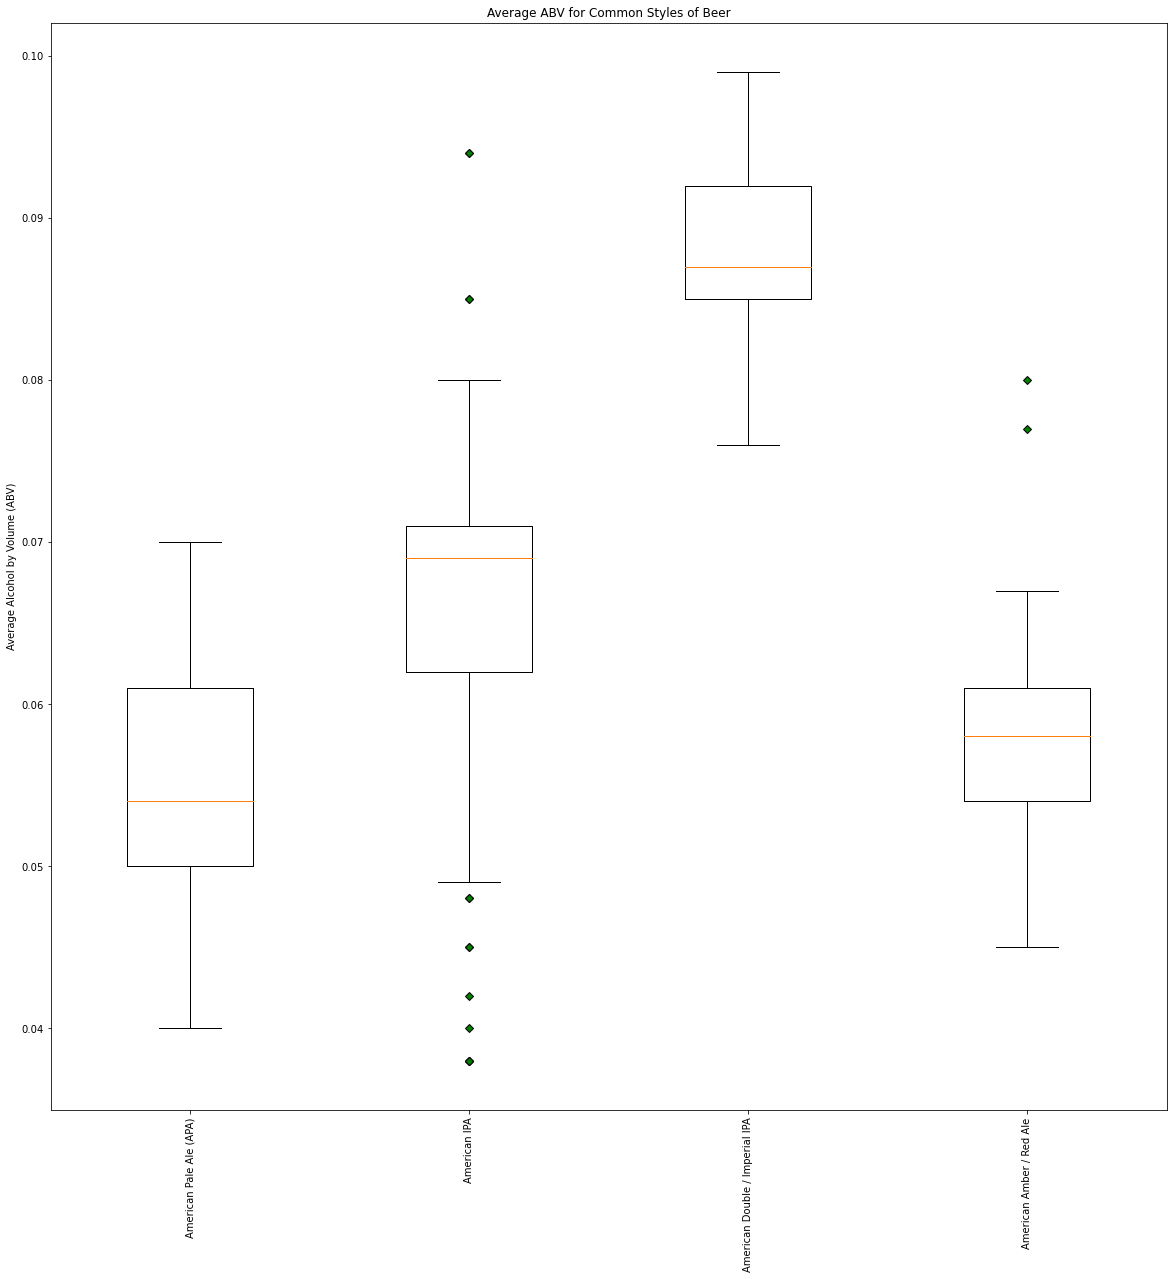

In [227]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
styles_abv_data[0]
x_values = np.arange(1, 5, 1)

plt.figure(figsize=(16,8))
green_diamond = dict(markerfacecolor='g', marker='D')
fig1, ax1 = plt.subplots(figsize = (20, 20))

ax1.set_title('Average ABV for Common Styles of Beer')
ax1.set_ylabel('Average Alcohol by Volume (ABV)')
ax1.boxplot(styles_abv_data, flierprops=green_diamond)
plt.xticks(x_values, styles, rotation= "vertical")
plt.savefig("boxPlots.png")